In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import re
import time
from collections import Counter


import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('omw-1.4')

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dimitris\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dimitris\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dimitris\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dimitris\AppData\Roaming\nltk_data...


True

In [2]:
# Read CSV file using pandas
df = pd.read_csv('datasets/bbc_text_cls.csv')
df

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,tech
2221,Spam e-mails tempt net shoppers\n\nComputer us...,tech
2222,Be careful how you code\n\nA new European dire...,tech
2223,US cyber security chief resigns\n\nThe man mak...,tech


In [4]:
# Split data to inputs and outputs
inputs = df['text']
labels = df['labels']

<Axes: >

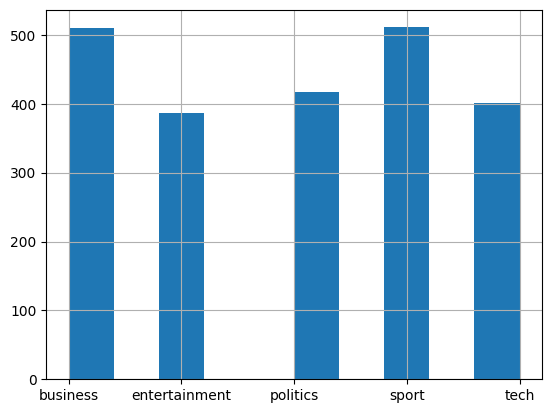

In [13]:
labels.hist()

In [14]:
# Train-test split
inputs_train, inputs_test, Ytrain, Ytest = train_test_split(
    inputs,labels,random_state=123)

### Determine Vocabulary size by counting unique words(V)

In [89]:
def myCountVectorizer(dataframe,limit=100):
    st = time.time()
    vocab = []
    for i, row in inputs.iteritems():
        row = re.sub(" , [0-2][0-9]:[0-5][0-9]", "", row)
        row = re.sub("[,|!|.|?|\"]", "", row)
        words = [w.lower() for w in row.split()]

        for j, word in enumerate(words):
            if word not in vocab:
                vocab.append(word)

        #I'm limiting the Vocab for speed      
        if i >= limit-1:
            break


    print('Vocabulary size(V) = %d, time = %.4f' 
              % (len(vocab), (time.time() - st)))

    
    
    st = time.time()
    #Initialize empty matrix of size V*colum1
    V = len(vocab)
    col1 = limit#len(df['text'])

    corpus = [[0] * V for _ in range(col1)]

    for i, row in df['text'].iteritems():
        row = re.sub(" , [0-2][0-9]:[0-5][0-9]", "", row)
        row = re.sub("[,|!|.|?|\"]", "", row)
        row = row.lower()
        words = [w.lower() for w in row.split()]
        for j, item in enumerate(vocab):
            for word in words:
                if word == item:
                    corpus[i][j]+=1

        if i >= limit-1:
            break        
    
    print(' time = %.4f' 
        % ((time.time() - st)))
    
    return vocab,corpus

In [90]:
vocab,corpus = myCountVectorizer(df)

Vocabulary size(V) = 38567, time = 66.2730


IndexError: list index out of range

In [15]:
vectorizer = CountVectorizer()
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

In [16]:
Xtrain

<1668x26287 sparse matrix of type '<class 'numpy.int64'>'
	with 337411 stored elements in Compressed Sparse Row format>

In [11]:
#Non zero elements
(Xtrain !=0).sum()/np.prod(Xtrain.shape)

0.007695239935415004

In [17]:
model = MultinomialNB()
model.fit(Xtrain,Ytrain)
print("train score:", model.score(Xtrain,Ytrain))
print("test score:", model.score(Xtest,Ytest))

train score: 0.9922062350119905
test score: 0.9712746858168761


In [18]:
# with stopwords
vectorizer = CountVectorizer(stop_words='english')
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain,Ytrain)
print("train score:", model.score(Xtrain,Ytrain))
print("test score:", model.score(Xtest,Ytest))

train score: 0.9928057553956835
test score: 0.9766606822262118


In [19]:
Xtrain

<1668x25995 sparse matrix of type '<class 'numpy.int64'>'
	with 242123 stored elements in Compressed Sparse Row format>

In [20]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
          return wordnet.NOUN

In [21]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self,doc):
        tokens = word_tokenize(doc)#fancier word split
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word,pos=get_wordnet_pos(tag)) \
                for word,tag in words_and_tags]

In [25]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain,Ytrain)
print("train score:", model.score(Xtrain,Ytrain))
print("test score:", model.score(Xtest,Ytest))

c:\Users\Dimitris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9922062350119905
test score: 0.9676840215439856


In [26]:
Xtrain

<1668x26000 sparse matrix of type '<class 'numpy.int64'>'
	with 327738 stored elements in Compressed Sparse Row format>

In [27]:
class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self,doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(t) for t in tokens]

In [28]:
vectorizer = CountVectorizer(tokenizer=StemTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain,Ytrain)
print("train score:", model.score(Xtrain,Ytrain))
print("test score:", model.score(Xtest,Ytest))

c:\Users\Dimitris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9892086330935251
test score: 0.9694793536804309


In [29]:
Xtrain

<1668x22828 sparse matrix of type '<class 'numpy.int64'>'
	with 335081 stored elements in Compressed Sparse Row format>

In [30]:
def simple_tokenizer(s):
    return s.split()

In [31]:
# String split tokenizer
vectorizer = CountVectorizer(tokenizer=simple_tokenizer)
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain,Ytrain)
print("train score:", model.score(Xtrain,Ytrain))
print("test score:", model.score(Xtest,Ytest))

c:\Users\Dimitris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9952038369304557
test score: 0.9712746858168761


In [32]:
Xtrain

<1668x52144 sparse matrix of type '<class 'numpy.int64'>'
	with 369097 stored elements in Compressed Sparse Row format>